Train the U-Net model

These codes are modified based on Abhinav Sagar, Nucleus Segmentation using U-Net, https://towardsdatascience.com/nucleus-segmentation-using-u-net-eceb14a9ced4

In [2]:
#import useful libraries
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage import io
import tensorflow as tf
from keras.preprocessing import image


In [3]:
BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 128 # for faster computing on kaggle
IMG_HEIGHT = 128 # for faster computing on kaggle
IMG_CHANNELS = 3 
TRAIN_PATH = './stage1_train/'
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

#load all the file name into training and testing directory
train_ids = next(os.walk(TRAIN_PATH))[1]# why [1]?

np.random.seed(10)#the 10th seed


In [4]:
# build X and Y train set
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()#output on the same line with time interval
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):#why _
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    #make tif from 256*256 to 128*128 to increase computational speed
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:#what is [2]
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask# what do this mask fun do?

Getting and resizing train images and masks ... 


C:\Users\ZKR\AppData\Local\Temp\ipykernel_6844\2171445504.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\ZKR\AppData\Local\Temp\ipykernel_6844\2171445504.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ze

In [5]:

# build data augmentation to avoid the overfitting of a model and also to increase the ability of our model to generalize.

# Creating the training Image and Mask generator (zoom in range[0.8,1.2])
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together
image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)#90% train data to fit
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

# flow method generate batch of augmented data
x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)#other 10% apart from 90%
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [6]:
#build U-net model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)#axis?
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])#tf.keras.metrics.MeanIoU(num_classes=2)
model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [7]:
# fit the model
#Stop training when a monitored metric has stopped improving.
earlystopper = EarlyStopping(patience=3, verbose=1)
# save a model or weights (in a checkpoint file) at some interval, 
#so the model or weights can be loaded later to continue the training from the state saved.
checkpointer = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
#default batch size is 32. We use fit_generator(), since there are data argumentation
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=100,
                              epochs=5, callbacks=[earlystopper, checkpointer])
results.history

c:\Users\ZKR\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
100/100 [==============================] - 60s 575ms/step - loss: 0.3044 - mean_io_u: 0.3962 - val_loss: 0.1242 - val_mean_io_u: 0.4006

Epoch 00001: val_loss improved from inf to 0.12419, saving model to model.h5
Epoch 2/5
100/100 [==============================] - 59s 584ms/step - loss: 0.1795 - mean_io_u: 0.3956 - val_loss: 0.0902 - val_mean_io_u: 0.4006

Epoch 00002: val_loss improved from 0.12419 to 0.09015, saving model to model.h5
Epoch 3/5
100/100 [==============================] - 73s 726ms/step - loss: 0.1568 - mean_io_u: 0.3962 - val_loss: 0.0792 - val_mean_io_u: 0.4006

Epoch 00003: val_loss improved from 0.09015 to 0.07924, saving model to model.h5
Epoch 4/5
100/100 [==============================] - 57s 570ms/step - loss: 0.1489 - mean_io_u: 0.3963 - val_loss: 0.0877 - val_mean_io_u: 0.4006

Epoch 00004: val_loss did not improve from 0.07924
Epoch 5/5
100/100 [==============================] - 64s 641ms/step - loss: 0.1316 - mean_io_u: 0.3960 - val_loss: 0.0853 

{'loss': [0.30441975593566895,
  0.17948876321315765,
  0.15675580501556396,
  0.14887863397598267,
  0.13161492347717285],
 'mean_io_u': [0.39616212248802185,
  0.39563581347465515,
  0.39617711305618286,
  0.39631524682044983,
  0.39596638083457947],
 'val_loss': [0.1241922378540039,
  0.09015121310949326,
  0.07924441993236542,
  0.08769774436950684,
  0.08525694906711578],
 'val_mean_io_u': [0.400643914937973,
  0.400643914937973,
  0.400643914937973,
  0.400643914937973,
  0.400643914937973]}

In [8]:
#save your loss data

mse = np.array((results.history['loss']))
val_mse=np.array((results.history['val_loss']))
#np.save('loss.npy', mse)
#np.save('val_loss.npy', val_mse)
miou = np.array((results.history['mean_io_u']))
val_miou=np.array((results.history['val_mean_io_u']))
#np.save('mean_io_u.npy', miou)
#np.save('val_mean_io_u.npy', val_miou)

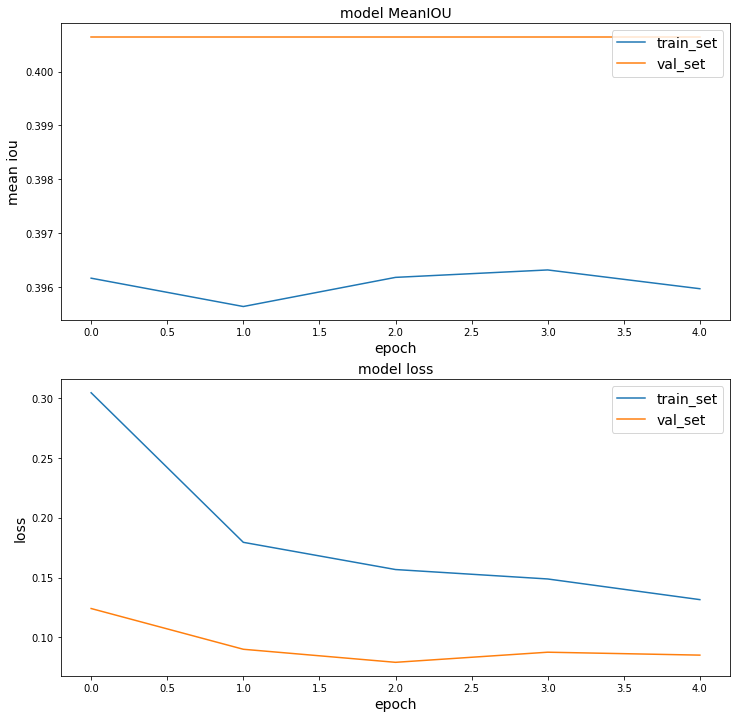

<Figure size 432x288 with 0 Axes>

In [11]:
# summarize history and plot the relevant data
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.plot(results.history['mean_io_u'])
plt.plot(results.history['val_mean_io_u'])
plt.title('model MeanIOU',fontsize=14)
plt.ylabel('mean iou',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train_set', 'val_set'], loc='upper right',fontsize=14)
plt.subplot(212)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss',fontsize=14)
plt.ylabel('loss',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train_set', 'val_set'], loc='upper right',fontsize=14)
plt.show()
plt.savefig('loss.png')
